In [1]:
from torch.utils.data import DataLoader
import time
import torch
from embeddings import EmbeddingSummation
from BookDataset import getBookDataset, BookDataset, NameSpace
from transformers import AutoTokenizer

In [2]:
train, val, test, featureSizes = getBookDataset('../Data_Train.xlsx', '../Data_Test.xlsx', returnValidation=False)
train.head()

,Title,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,author_0,author_1,author_2,author_3,author_4
0,The Prisoner's Gold (The Hunters 3),0.0,0.409600,0.468746,THE HUNTERS return in their third brilliant no...,2,1,5.398163,0,1,1,1,1
1,Guru Dutt: A Tragedy in Three Acts,0.0,0.370151,0.520389,A layered portrait of a troubled genius for wh...,50,3,5.317777,43,1,1,1,1
2,Leviathan (Penguin Classics),0.0,0.849347,0.441125,"""During the time men live without a common Pow...",126,7,5.703783,0,1,1,1,1
3,A Pocket Full of Rye (Miss Marple),0.0,0.452122,0.513718,A handful of grain is found in the pocket of a...,64,6,5.198497,12,1,1,1,1
4,LIFE 70 Years of Extraordinary Photography,1.0,1.000000,0.263277,"For seven decades, ""Life"" has been thrilling t...",157,2,6.873806,0,1,1,1,1


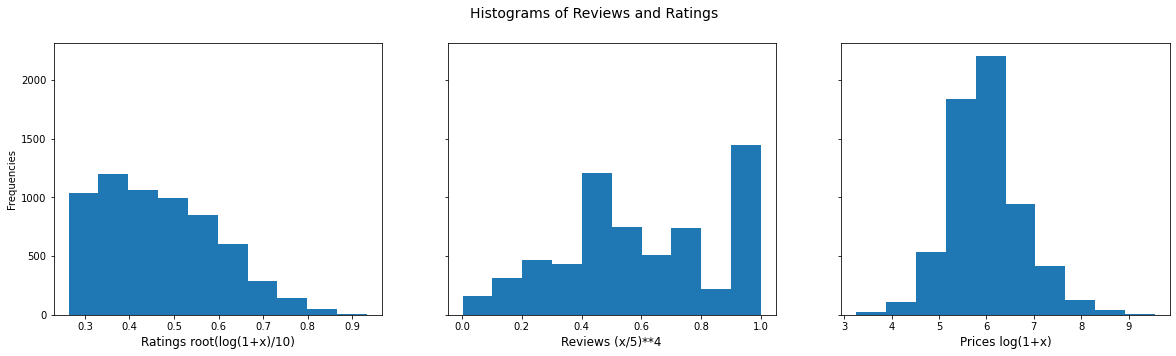

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
plt.suptitle('Histograms of Reviews and Ratings', fontsize=14)

ax1.hist(train.Ratings)
ax1.set_xlabel('Ratings root(log(1+x)/10)', fontsize=12)
ax1.set_ylabel('Frequencies')

ax2.hist(train.Reviews)
ax2.set_xlabel('Reviews (x/5)**4', fontsize=12)

ax3.hist(train.Price)
ax3.set_xlabel('Prices log(1+x)', fontsize=12);

In [4]:
loader = BookDataset(train).loader()
batch = next(iter(loader))
for key in batch:
    print(key.ljust(15), str(batch[key].dtype).ljust(15), list(batch[key].shape))

Author          torch.int64     [8, 5]
Genre           torch.int64     [8]
BookCategory    torch.int64     [8]
Numeric         torch.float32   [8, 3]
TitleInput      torch.int64     [8, 37]
TitleMask       torch.int64     [8, 37]
SynopsisInput   torch.int64     [8, 346]
SynopsisMask    torch.int64     [8, 346]
Price           torch.float32   [8]


In [5]:
loader = BookDataset(test).loader()
batch = next(iter(loader))
for key in batch:
    print(key.ljust(15), str(batch[key].dtype).ljust(15), list(batch[key].shape))

Author          torch.int64     [8, 5]
Genre           torch.int64     [8]
BookCategory    torch.int64     [8]
Numeric         torch.float32   [8, 3]
TitleInput      torch.int64     [8, 31]
TitleMask       torch.int64     [8, 31]
SynopsisInput   torch.int64     [8, 403]
SynopsisMask    torch.int64     [8, 403]
